In [1]:
import os
import pandas as pd
os.chdir("../../")


import torch
from pair_classification.bert_finetuning.finetune import set_configs, timer, parse_data_to_bert_format, setup_bert_model, train, validate, predict_for_test
from pair_classification.bert_finetuning.hugginface_pair_clf import BertForSequencePairClassificationDSSMWithAttention
from pair_classification.bert_finetuning.util import sigmoid_np

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()


True

In [2]:
config = set_configs('models/bert_finetuning/config.yml')
device = torch.device(f"cuda:{config['torch_device']}")

# Data processing. Train/val split, tokenization. Seed fixed.

In [3]:
with timer('Read data and convert to BERT format'):
    train_loader, val_loader, test_loader, class_names = parse_data_to_bert_format(
        path_to_data=config['path_to_data'],
        train_file_name=config['train_file_name'],
        text_col_name_1=config['text_col_name_1'],
        text_col_name_2=config['text_col_name_2'],
        label_col_name=config['label_col_name'],
        path_to_pretrained_model=config['path_to_pretrained_model'],
        max_seq_length=config['max_seq_length'],
        batch_size=config['batch_size'],
        validate=config['validate'],
        predict_for_test=config['predict_for_test'],
        test_file_name=config['test_file_name'],
        toy=config['toy'],
        dssm=True
    )


loaded 404290 train records


  0%|          | 0/404290 [00:00<?, ?it/s]

There are 1 lines longer than 148


100%|██████████| 404290/404290 [01:11<00:00, 5689.21it/s]


There are 19 lines longer than 148


  0%|          | 601/2345796 [00:00<06:30, 6008.24it/s]

There are 8 lines longer than 148


100%|██████████| 2345796/2345796 [06:55<00:00, 5650.52it/s]


There are 10 lines longer than 148
[Read data and convert to BERT format] done in 1046 s


## Prepare bert model

In [4]:
with timer('Setting up BERT model'):
    model, optimizer = setup_bert_model(
        path_to_pretrained_model=config['path_to_pretrained_model'],
        epochs=config['epochs'],
        lrate=config['lrate'], lrate_clf=config['lrate_clf'],
        batch_size=config['batch_size'],
        accum_steps=config['accum_steps'], lin_dim=config['lin_dim'],
        lin_dropout_prob=config['lin_dropout_prob'],warmup=config['warmup'],
        apex_mixed_precision=config['apex_mixed_precision'],
        seed=config['seed'], device=device, train_loader=train_loader,
        clf_class=BertForSequencePairClassificationDSSMWithAttention
    )

Building PyTorch model from configuration: {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

Converting TensorFlow checkpoint from /home/mf_side/quora_question_pairs_kaggle/models/bert_finetuning/uncased_L-12_H-768_A-12/bert_model.ckpt
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/embeddings/word_embeddings with shape [30522, 768]
Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_0/attention/outp

### Load metric learned bert encoder wieights

In [5]:
encoder_state_dict = torch.load(config['path_to_output_model'] + 'bert_triplets_unfreezed_2.bin')
model.load_state_dict(encoder_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['classifier_fc_attention.weight', 'classifier.0.weight', 'classifier.0.bias', 'classifier.2.weight', 'classifier.2.bias', 'classifier.2.running_mean', 'classifier.2.running_var', 'classifier.4.weight', 'classifier.4.bias', 'pair_classifier.0.weight', 'pair_classifier.0.bias', 'pair_classifier.0.running_mean', 'pair_classifier.0.running_var', 'pair_classifier.2.weight', 'pair_classifier.2.bias'], unexpected_keys=[])

# Training pair classification

### Freezed bert token enconding. Finetune only head of classifier. 1 epoch.

  0%|          | 0/7581 [00:00<?, ?it/s]

Iter 76/7581. Postfix = loss=0.713
Iter 152/7581. Postfix = loss=0.699
Iter 228/7581. Postfix = loss=0.68
Iter 304/7581. Postfix = loss=0.67
Iter 380/7581. Postfix = loss=0.656
Iter 456/7581. Postfix = loss=0.654
Iter 532/7581. Postfix = loss=0.645
Iter 608/7581. Postfix = loss=0.642
Iter 684/7581. Postfix = loss=0.618
Iter 760/7581. Postfix = loss=0.631
Iter 836/7581. Postfix = loss=0.63
Iter 912/7581. Postfix = loss=0.63
Iter 988/7581. Postfix = loss=0.617
Iter 1064/7581. Postfix = loss=0.595
Iter 1140/7581. Postfix = loss=0.62
Iter 1216/7581. Postfix = loss=0.605
Iter 1292/7581. Postfix = loss=0.596
Iter 1368/7581. Postfix = loss=0.607
Iter 1444/7581. Postfix = loss=0.586
Iter 1520/7581. Postfix = loss=0.601
Iter 1596/7581. Postfix = loss=0.594
Iter 1672/7581. Postfix = loss=0.579
Iter 1748/7581. Postfix = loss=0.568
Iter 1824/7581. Postfix = loss=0.576
Iter 1900/7581. Postfix = loss=0.58
Iter 1976/7581. Postfix = loss=0.582
Iter 2052/7581. Postfix = loss=0.569
Iter 2128/7581. Postf

100%|██████████| 7581/7581 [14:47<00:00,  8.54it/s, loss=0.478]

  0%|          | 0/843 [00:00<?, ?it/s]

Iter 9/843. Postfix = None
Iter 18/843. Postfix = None
Iter 27/843. Postfix = None
Iter 36/843. Postfix = None
Iter 45/843. Postfix = None
Iter 54/843. Postfix = None
Iter 63/843. Postfix = None
Iter 72/843. Postfix = None
Iter 81/843. Postfix = None
Iter 90/843. Postfix = None
Iter 99/843. Postfix = None
Iter 108/843. Postfix = None
Iter 117/843. Postfix = None
Iter 126/843. Postfix = None
Iter 135/843. Postfix = None
Iter 144/843. Postfix = None
Iter 153/843. Postfix = None
Iter 162/843. Postfix = None
Iter 171/843. Postfix = None
Iter 180/843. Postfix = None
Iter 189/843. Postfix = None
Iter 198/843. Postfix = None
Iter 207/843. Postfix = None
Iter 216/843. Postfix = None
Iter 225/843. Postfix = None
Iter 234/843. Postfix = None
Iter 243/843. Postfix = None
Iter 252/843. Postfix = None
Iter 261/843. Postfix = None
Iter 270/843. Postfix = None
Iter 279/843. Postfix = None
Iter 288/843. Postfix = None
Iter 297/843. Postfix = None
Iter 306/843. Postfix = None
Iter 315/843. Postfix = No

100%|██████████| 1/1 [16:16<00:00, 976.96s/it, avg_loss=0.541]


Loss function:  0.4355151132147953
F1-score (micro):  0.8000939919364812
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     25503
           1       0.73      0.72      0.73     14926

    accuracy                           0.80     40429
   macro avg       0.79      0.78      0.78     40429
weighted avg       0.80      0.80      0.80     40429

[Training] done in 979 s


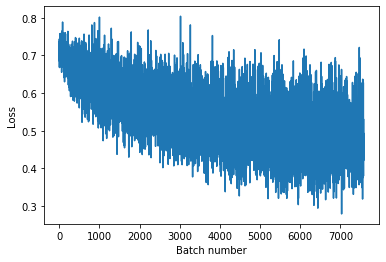

In [6]:
with timer('Training'):
    model = train(
        model=model,
        optimizer=optimizer,
        epochs=1,
        accum_steps=config['accum_steps'],
        apex_mixed_precision=config['apex_mixed_precision'],       
        output_model_file_name=config['output_model_file_name'],
        device=device,
        train_loader=train_loader,
        batch_size=config['batch_size'],
        class_names=class_names,
        val_loader=val_loader,
        bert_freezed=True
    )

In [7]:
torch.save(model.state_dict(), config['path_to_output_model'] + 'bert_pair_clf_prod_with_att_freezed.bin')

### Epoch 1 after unfreeze

  0%|          | 0/7581 [00:00<?, ?it/s]

Iter 76/7581. Postfix = loss=0.471
Iter 152/7581. Postfix = loss=0.477
Iter 228/7581. Postfix = loss=0.47
Iter 304/7581. Postfix = loss=0.476
Iter 380/7581. Postfix = loss=0.482
Iter 456/7581. Postfix = loss=0.472
Iter 532/7581. Postfix = loss=0.476
Iter 608/7581. Postfix = loss=0.468
Iter 684/7581. Postfix = loss=0.467
Iter 760/7581. Postfix = loss=0.468
Iter 836/7581. Postfix = loss=0.467
Iter 912/7581. Postfix = loss=0.459
Iter 988/7581. Postfix = loss=0.462
Iter 1064/7581. Postfix = loss=0.455
Iter 1140/7581. Postfix = loss=0.473
Iter 1216/7581. Postfix = loss=0.46
Iter 1292/7581. Postfix = loss=0.48
Iter 1368/7581. Postfix = loss=0.467
Iter 1444/7581. Postfix = loss=0.461
Iter 1520/7581. Postfix = loss=0.466
Iter 1596/7581. Postfix = loss=0.439
Iter 1672/7581. Postfix = loss=0.451
Iter 1748/7581. Postfix = loss=0.453
Iter 1824/7581. Postfix = loss=0.469
Iter 1900/7581. Postfix = loss=0.456
Iter 1976/7581. Postfix = loss=0.451
Iter 2052/7581. Postfix = loss=0.445
Iter 2128/7581. Po

100%|██████████| 7581/7581 [41:15<00:00,  3.06it/s, loss=0.428]

  0%|          | 0/843 [00:00<?, ?it/s]

Iter 9/843. Postfix = None
Iter 18/843. Postfix = None
Iter 27/843. Postfix = None
Iter 36/843. Postfix = None
Iter 45/843. Postfix = None
Iter 54/843. Postfix = None
Iter 63/843. Postfix = None
Iter 72/843. Postfix = None
Iter 81/843. Postfix = None
Iter 90/843. Postfix = None
Iter 99/843. Postfix = None
Iter 108/843. Postfix = None
Iter 117/843. Postfix = None
Iter 126/843. Postfix = None
Iter 135/843. Postfix = None
Iter 144/843. Postfix = None
Iter 153/843. Postfix = None
Iter 162/843. Postfix = None
Iter 171/843. Postfix = None
Iter 180/843. Postfix = None
Iter 189/843. Postfix = None
Iter 198/843. Postfix = None
Iter 207/843. Postfix = None
Iter 216/843. Postfix = None
Iter 225/843. Postfix = None
Iter 234/843. Postfix = None
Iter 243/843. Postfix = None
Iter 252/843. Postfix = None
Iter 261/843. Postfix = None
Iter 270/843. Postfix = None
Iter 279/843. Postfix = None
Iter 288/843. Postfix = None
Iter 297/843. Postfix = None
Iter 306/843. Postfix = None
Iter 315/843. Postfix = No

100%|██████████| 1/1 [42:45<00:00, 2565.52s/it, avg_loss=0.44]


Loss function:  0.3663593129913147
F1-score (micro):  0.8358851319597319
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     25503
           1       0.78      0.78      0.78     14926

    accuracy                           0.84     40429
   macro avg       0.82      0.82      0.82     40429
weighted avg       0.84      0.84      0.84     40429

[Training] done in 2567 s


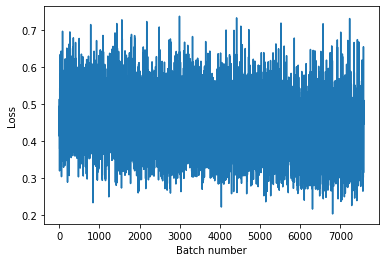

In [8]:
with timer('Training'):
    model = train(
        model=model,
        optimizer=optimizer,
        epochs=1,
        accum_steps=config['accum_steps'],
        apex_mixed_precision=config['apex_mixed_precision'],       
        output_model_file_name=config['output_model_file_name'],
        device=device,
        train_loader=train_loader,
        batch_size=config['batch_size'],
        class_names=class_names,
        val_loader=val_loader,
        bert_freezed=False
    )


In [9]:
torch.save(model.state_dict(), config['path_to_output_model'] + 'bert_pair_clf_prod_with_att_unfreezed_1.bin')

### Epoch 2 after unfreeze

  0%|          | 0/7581 [00:00<?, ?it/s]

Iter 76/7581. Postfix = loss=0.384
Iter 152/7581. Postfix = loss=0.376
Iter 228/7581. Postfix = loss=0.357
Iter 304/7581. Postfix = loss=0.389
Iter 380/7581. Postfix = loss=0.366
Iter 456/7581. Postfix = loss=0.396
Iter 532/7581. Postfix = loss=0.399
Iter 608/7581. Postfix = loss=0.388
Iter 684/7581. Postfix = loss=0.371
Iter 760/7581. Postfix = loss=0.346
Iter 836/7581. Postfix = loss=0.383
Iter 912/7581. Postfix = loss=0.382
Iter 988/7581. Postfix = loss=0.363
Iter 1064/7581. Postfix = loss=0.384
Iter 1140/7581. Postfix = loss=0.379
Iter 1216/7581. Postfix = loss=0.373
Iter 1292/7581. Postfix = loss=0.36
Iter 1368/7581. Postfix = loss=0.391
Iter 1444/7581. Postfix = loss=0.36
Iter 1520/7581. Postfix = loss=0.357
Iter 1596/7581. Postfix = loss=0.362
Iter 1672/7581. Postfix = loss=0.377
Iter 1748/7581. Postfix = loss=0.377
Iter 1824/7581. Postfix = loss=0.346
Iter 1900/7581. Postfix = loss=0.391
Iter 1976/7581. Postfix = loss=0.389
Iter 2052/7581. Postfix = loss=0.369
Iter 2128/7581. P

100%|██████████| 7581/7581 [41:15<00:00,  3.06it/s, loss=0.356]

  0%|          | 0/843 [00:00<?, ?it/s]

Iter 9/843. Postfix = None
Iter 18/843. Postfix = None
Iter 27/843. Postfix = None
Iter 36/843. Postfix = None
Iter 45/843. Postfix = None
Iter 54/843. Postfix = None
Iter 63/843. Postfix = None
Iter 72/843. Postfix = None
Iter 81/843. Postfix = None
Iter 90/843. Postfix = None
Iter 99/843. Postfix = None
Iter 108/843. Postfix = None
Iter 117/843. Postfix = None
Iter 126/843. Postfix = None
Iter 135/843. Postfix = None
Iter 144/843. Postfix = None
Iter 153/843. Postfix = None
Iter 162/843. Postfix = None
Iter 171/843. Postfix = None
Iter 180/843. Postfix = None
Iter 189/843. Postfix = None
Iter 198/843. Postfix = None
Iter 207/843. Postfix = None
Iter 216/843. Postfix = None
Iter 225/843. Postfix = None
Iter 234/843. Postfix = None
Iter 243/843. Postfix = None
Iter 252/843. Postfix = None
Iter 261/843. Postfix = None
Iter 270/843. Postfix = None
Iter 279/843. Postfix = None
Iter 288/843. Postfix = None
Iter 297/843. Postfix = None
Iter 306/843. Postfix = None
Iter 315/843. Postfix = No

100%|██████████| 1/1 [42:45<00:00, 2565.19s/it, avg_loss=0.367]


Loss function:  0.34039936999218107
F1-score (micro):  0.8532983749288878
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     25503
           1       0.81      0.79      0.80     14926

    accuracy                           0.85     40429
   macro avg       0.84      0.84      0.84     40429
weighted avg       0.85      0.85      0.85     40429

[Training] done in 2567 s


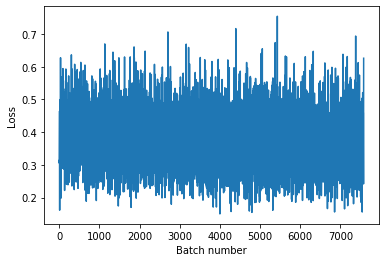

In [10]:
with timer('Training'):
    model = train(
        model=model,
        optimizer=optimizer,
        epochs=1,
        accum_steps=config['accum_steps'],
        apex_mixed_precision=config['apex_mixed_precision'],       
        output_model_file_name=config['output_model_file_name'],
        device=device,
        train_loader=train_loader,
        batch_size=config['batch_size'],
        class_names=class_names,
        val_loader=val_loader,
        bert_freezed=False
    )


In [11]:
torch.save(model.state_dict(), config['path_to_output_model'] + 'bert_pair_clf_prod_with_att_unfreezed_2.bin')

### Epoch 3 after unfreeze

  0%|          | 0/7581 [00:00<?, ?it/s]

Iter 76/7581. Postfix = loss=0.297
Iter 152/7581. Postfix = loss=0.31
Iter 228/7581. Postfix = loss=0.306
Iter 304/7581. Postfix = loss=0.294
Iter 380/7581. Postfix = loss=0.317
Iter 456/7581. Postfix = loss=0.325
Iter 532/7581. Postfix = loss=0.318
Iter 608/7581. Postfix = loss=0.315
Iter 684/7581. Postfix = loss=0.321
Iter 760/7581. Postfix = loss=0.317
Iter 836/7581. Postfix = loss=0.298
Iter 912/7581. Postfix = loss=0.316
Iter 988/7581. Postfix = loss=0.306
Iter 1064/7581. Postfix = loss=0.321
Iter 1140/7581. Postfix = loss=0.317
Iter 1216/7581. Postfix = loss=0.315
Iter 1292/7581. Postfix = loss=0.306
Iter 1368/7581. Postfix = loss=0.327
Iter 1444/7581. Postfix = loss=0.311
Iter 1520/7581. Postfix = loss=0.318
Iter 1596/7581. Postfix = loss=0.34
Iter 1672/7581. Postfix = loss=0.331
Iter 1748/7581. Postfix = loss=0.3
Iter 1824/7581. Postfix = loss=0.299
Iter 1900/7581. Postfix = loss=0.323
Iter 1976/7581. Postfix = loss=0.317
Iter 2052/7581. Postfix = loss=0.313
Iter 2128/7581. Pos

100%|██████████| 7581/7581 [41:16<00:00,  3.06it/s, loss=0.33]

  0%|          | 0/843 [00:00<?, ?it/s]

Iter 9/843. Postfix = None
Iter 18/843. Postfix = None
Iter 27/843. Postfix = None
Iter 36/843. Postfix = None
Iter 45/843. Postfix = None
Iter 54/843. Postfix = None
Iter 63/843. Postfix = None
Iter 72/843. Postfix = None
Iter 81/843. Postfix = None
Iter 90/843. Postfix = None
Iter 99/843. Postfix = None
Iter 108/843. Postfix = None
Iter 117/843. Postfix = None
Iter 126/843. Postfix = None
Iter 135/843. Postfix = None
Iter 144/843. Postfix = None
Iter 153/843. Postfix = None
Iter 162/843. Postfix = None
Iter 171/843. Postfix = None
Iter 180/843. Postfix = None
Iter 189/843. Postfix = None
Iter 198/843. Postfix = None
Iter 207/843. Postfix = None
Iter 216/843. Postfix = None
Iter 225/843. Postfix = None
Iter 234/843. Postfix = None
Iter 243/843. Postfix = None
Iter 252/843. Postfix = None
Iter 261/843. Postfix = None
Iter 270/843. Postfix = None
Iter 279/843. Postfix = None
Iter 288/843. Postfix = None
Iter 297/843. Postfix = None
Iter 306/843. Postfix = None
Iter 315/843. Postfix = No

100%|██████████| 1/1 [42:46<00:00, 2566.26s/it, avg_loss=0.311]


Loss function:  0.3267937101305986
F1-score (micro):  0.8579485023126963
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     25503
           1       0.81      0.81      0.81     14926

    accuracy                           0.86     40429
   macro avg       0.85      0.85      0.85     40429
weighted avg       0.86      0.86      0.86     40429

[Training] done in 2568 s


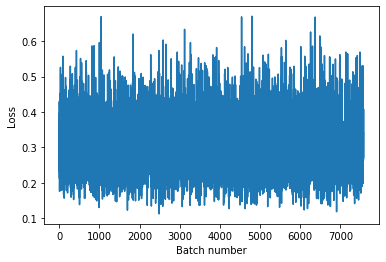

In [12]:
with timer('Training'):
    model = train(
        model=model,
        optimizer=optimizer,
        epochs=1,
        accum_steps=config['accum_steps'],
        apex_mixed_precision=config['apex_mixed_precision'],       
        output_model_file_name=config['output_model_file_name'],
        device=device,
        train_loader=train_loader,
        batch_size=config['batch_size'],
        class_names=class_names,
        val_loader=val_loader,
        bert_freezed=False
    )


In [13]:
torch.save(model.state_dict(), config['path_to_output_model'] + 'bert_pair_clf_prod_with_att_unfreezed_3.bin')

### Epoch 4 after unfreeze

In [ ]:
with timer('Training'):
    model = train(
        model=model,
        optimizer=optimizer,
        epochs=1,
        accum_steps=config['accum_steps'],
        apex_mixed_precision=config['apex_mixed_precision'],       
        output_model_file_name=config['output_model_file_name'],
        device=device,
        train_loader=train_loader,
        batch_size=config['batch_size'],
        class_names=class_names,
        val_loader=val_loader,
        bert_freezed=False
    )


In [ ]:
torch.save(model.state_dict(), config['path_to_output_model'] + 'bert_pair_clf_prod_with_att_unfreezed_4.bin')

In [5]:
model.load_state_dict(torch.load(config['path_to_output_model'] + 'bert_pair_clf_prod_with_att_unfreezed_4.bin'))

<All keys matched successfully>

In [6]:
with timer('Validate'):
    validate(
        torch_loader=val_loader,
        model=model,
        batch_size=config['batch_size'],
        class_names=class_names,
        device=device
    )


  0%|          | 0/843 [00:00<?, ?it/s]

Iter 9/843. Postfix = None
Iter 18/843. Postfix = None
Iter 27/843. Postfix = None
Iter 36/843. Postfix = None
Iter 45/843. Postfix = None
Iter 54/843. Postfix = None
Iter 63/843. Postfix = None
Iter 72/843. Postfix = None
Iter 81/843. Postfix = None
Iter 90/843. Postfix = None
Iter 99/843. Postfix = None
Iter 108/843. Postfix = None
Iter 117/843. Postfix = None
Iter 126/843. Postfix = None
Iter 135/843. Postfix = None
Iter 144/843. Postfix = None
Iter 153/843. Postfix = None
Iter 162/843. Postfix = None
Iter 171/843. Postfix = None
Iter 180/843. Postfix = None
Iter 189/843. Postfix = None
Iter 198/843. Postfix = None
Iter 207/843. Postfix = None
Iter 216/843. Postfix = None
Iter 225/843. Postfix = None
Iter 234/843. Postfix = None
Iter 243/843. Postfix = None
Iter 252/843. Postfix = None
Iter 261/843. Postfix = None
Iter 270/843. Postfix = None
Iter 279/843. Postfix = None
Iter 288/843. Postfix = None
Iter 297/843. Postfix = None
Iter 306/843. Postfix = None
Iter 315/843. Postfix = No

100%|██████████| 843/843 [01:30<00:00,  9.29it/s]

Loss function:  0.16967485976298302
F1-score (micro):  0.9400183036928937
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     25503
           1       0.92      0.92      0.92     14926

    accuracy                           0.94     40429
   macro avg       0.94      0.94      0.94     40429
weighted avg       0.94      0.94      0.94     40429

[Validate] done in 91 s


### Epoch 5 after unfreeze. Increase precision with low pos_weight value = 0.37. 

  0%|          | 0/7581 [00:00<?, ?it/s]

Iter 76/7581. Postfix = loss=0.162
Iter 152/7581. Postfix = loss=0.16
Iter 228/7581. Postfix = loss=0.166
Iter 304/7581. Postfix = loss=0.152
Iter 380/7581. Postfix = loss=0.151
Iter 456/7581. Postfix = loss=0.155
Iter 532/7581. Postfix = loss=0.16
Iter 608/7581. Postfix = loss=0.154
Iter 684/7581. Postfix = loss=0.154
Iter 760/7581. Postfix = loss=0.15
Iter 836/7581. Postfix = loss=0.163
Iter 912/7581. Postfix = loss=0.16
Iter 988/7581. Postfix = loss=0.145
Iter 1064/7581. Postfix = loss=0.159
Iter 1140/7581. Postfix = loss=0.166
Iter 1216/7581. Postfix = loss=0.142
Iter 1292/7581. Postfix = loss=0.158
Iter 1368/7581. Postfix = loss=0.159
Iter 1444/7581. Postfix = loss=0.155
Iter 1520/7581. Postfix = loss=0.16
Iter 1596/7581. Postfix = loss=0.143
Iter 1672/7581. Postfix = loss=0.155
Iter 1748/7581. Postfix = loss=0.156
Iter 1824/7581. Postfix = loss=0.153
Iter 1900/7581. Postfix = loss=0.149
Iter 1976/7581. Postfix = loss=0.143
Iter 2052/7581. Postfix = loss=0.154
Iter 2128/7581. Post

100%|██████████| 7581/7581 [41:17<00:00,  3.06it/s, loss=0.156]

  0%|          | 0/843 [00:00<?, ?it/s]

Iter 9/843. Postfix = None
Iter 18/843. Postfix = None
Iter 27/843. Postfix = None
Iter 36/843. Postfix = None
Iter 45/843. Postfix = None
Iter 54/843. Postfix = None
Iter 63/843. Postfix = None
Iter 72/843. Postfix = None
Iter 81/843. Postfix = None
Iter 90/843. Postfix = None
Iter 99/843. Postfix = None
Iter 108/843. Postfix = None
Iter 117/843. Postfix = None
Iter 126/843. Postfix = None
Iter 135/843. Postfix = None
Iter 144/843. Postfix = None
Iter 153/843. Postfix = None
Iter 162/843. Postfix = None
Iter 171/843. Postfix = None
Iter 180/843. Postfix = None
Iter 189/843. Postfix = None
Iter 198/843. Postfix = None
Iter 207/843. Postfix = None
Iter 216/843. Postfix = None
Iter 225/843. Postfix = None
Iter 234/843. Postfix = None
Iter 243/843. Postfix = None
Iter 252/843. Postfix = None
Iter 261/843. Postfix = None
Iter 270/843. Postfix = None
Iter 279/843. Postfix = None
Iter 288/843. Postfix = None
Iter 297/843. Postfix = None
Iter 306/843. Postfix = None
Iter 315/843. Postfix = No

100%|██████████| 1/1 [42:47<00:00, 2567.55s/it, avg_loss=0.152]


Loss function:  0.17834792120418475
F1-score (micro):  0.9282940463528655
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     25503
           1       0.94      0.86      0.90     14926

    accuracy                           0.93     40429
   macro avg       0.93      0.91      0.92     40429
weighted avg       0.93      0.93      0.93     40429

[Training] done in 2570 s


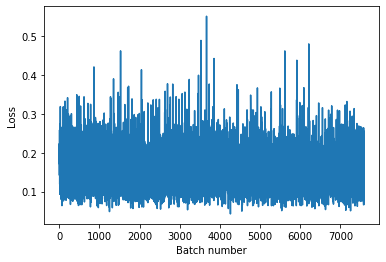

In [7]:
with timer('Training'):
    model = train(
        model=model,
        optimizer=optimizer,
        epochs=1,
        accum_steps=config['accum_steps'],
        apex_mixed_precision=config['apex_mixed_precision'],       
        output_model_file_name=config['output_model_file_name'],
        device=device,
        train_loader=train_loader,
        batch_size=config['batch_size'],
        class_names=class_names,
        val_loader=val_loader,
        bert_freezed=False,
        weight=[0.37]
    )


In [8]:
torch.save(model.state_dict(), config['path_to_output_model'] + 'bert_pair_clf_prod_with_att_unfreezed_5_weighted.bin')

# Make test prediction

In [5]:
model.load_state_dict(torch.load(config['path_to_output_model'] + 'bert_pair_clf_prod_with_att_unfreezed_5_weighted.bin'))

<All keys matched successfully>

In [6]:
if config['predict_for_test']:
    with timer('Predicting for test set'):
        preds = predict_for_test(
            torch_loader=test_loader,
            model=model,
            batch_size=config['batch_size'],
            test_pred_file_name=config['test_pred_file_name'],
            class_names=class_names,
            device=device
        )


  0%|          | 0/48871 [00:00<?, ?it/s]

Iter 489/48871. Postfix = None
Iter 978/48871. Postfix = None
Iter 1467/48871. Postfix = None
Iter 1956/48871. Postfix = None
Iter 2445/48871. Postfix = None
Iter 2934/48871. Postfix = None
Iter 3423/48871. Postfix = None
Iter 3912/48871. Postfix = None
Iter 4401/48871. Postfix = None
Iter 4890/48871. Postfix = None
Iter 5379/48871. Postfix = None
Iter 5868/48871. Postfix = None
Iter 6357/48871. Postfix = None
Iter 6846/48871. Postfix = None
Iter 7335/48871. Postfix = None
Iter 7824/48871. Postfix = None
Iter 8313/48871. Postfix = None
Iter 8802/48871. Postfix = None
Iter 9291/48871. Postfix = None
Iter 9780/48871. Postfix = None
Iter 10269/48871. Postfix = None
Iter 10758/48871. Postfix = None
Iter 11247/48871. Postfix = None
Iter 11736/48871. Postfix = None
Iter 12225/48871. Postfix = None
Iter 12714/48871. Postfix = None
Iter 13203/48871. Postfix = None
Iter 13692/48871. Postfix = None
Iter 14181/48871. Postfix = None
Iter 14670/48871. Postfix = None
Iter 15159/48871. Postfix = None

100%|██████████| 48871/48871 [1:26:48<00:00,  9.38it/s]


[Predicting for test set] done in 5214 s


In [8]:
test_preds = pd.DataFrame(sigmoid_np(preds), columns=['is_duplicate'])
test_preds.to_csv('./test_probs_att.csv', index=True, index_label='test_id')